In [1]:
import tkinter as tk
from tkinter import ttk, messagebox
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
from sklearn.datasets import fetch_california_housing

In [ ]:
class LinearRegressionApp:
    def __init__(self, root):
        self.root = root
        self.root.title("Linear Regression Playground")
        self.root.geometry("1300x750")

        # --- 1. LOAD DỮ LIỆU ---
        raw_data = fetch_california_housing()
        self.df = pd.DataFrame(raw_data.data, columns=raw_data.feature_names)
        self.target = pd.Series(raw_data.target, name="MedHouseVal")
        
        # Variables
        self.feature_vars = {}
        self.selected_features = []
        
        # Lưu trữ các thông số đã train để dùng cho dự đoán sau này
        self.trained_model = None
        self.train_stats = {} # Lưu mean, std
        self.input_entries = {} # Lưu các ô nhập liệu dự đoán
        
        # --- 2. GIAO DIỆN (UI) ---
        self.create_widgets()

    def create_widgets(self):
        # === CỘT TRÁI: CẤU HÌNH ===
        left_frame = ttk.Frame(self.root, padding="10")
        left_frame.pack(side=tk.LEFT, fill=tk.Y)

        # A. Chọn Features
        ttk.Label(left_frame, text="1. Chọn Features (Đầu vào):", font=("Arial", 11, "bold")).pack(anchor=tk.W)
        
        feature_frame = ttk.LabelFrame(left_frame, text="Features List")
        feature_frame.pack(fill=tk.X, pady=5)

        for col in self.df.columns:
            var = tk.BooleanVar()
            chk = ttk.Checkbutton(feature_frame, text=col, variable=var)
            chk.pack(anchor=tk.W)
            self.feature_vars[col] = var
        
        self.feature_vars['MedInc'].set(True)

        # B. Cấu hình Hyperparameters
        ttk.Label(left_frame, text="2. Cấu hình Model:", font=("Arial", 11, "bold")).pack(anchor=tk.W, pady=(15, 5))
        param_frame = ttk.LabelFrame(left_frame, text="Hyperparameters")
        param_frame.pack(fill=tk.X, pady=5)

        ttk.Label(param_frame, text="Epochs:").grid(row=0, column=0, padx=5, pady=5)
        self.entry_epochs = ttk.Entry(param_frame, width=8)
        self.entry_epochs.insert(0, "1000")
        self.entry_epochs.grid(row=0, column=1)

        ttk.Label(param_frame, text="L. Rate:").grid(row=1, column=0, padx=5, pady=5)
        self.entry_lr = ttk.Entry(param_frame, width=8)
        self.entry_lr.insert(0, "0.1")
        self.entry_lr.grid(row=1, column=1)

        # C. Nút Train
        self.btn_train = ttk.Button(left_frame, text="HUẤN LUYỆN NGAY", command=self.train_model)
        self.btn_train.pack(fill=tk.X, pady=15)

        # D. Log Text
        self.log_text = tk.Text(left_frame, height=10, width=35, state=tk.DISABLED, bg="#f4f4f4", font=("Consolas", 9))
        self.log_text.pack(fill=tk.X, pady=5)

        # === CỘT GIỮA: KHU VỰC TEST (MỚI THÊM) ===
        # Tạo frame riêng cho phần nhập liệu dự đoán
        self.test_frame = ttk.LabelFrame(left_frame, text="3. DỰ ĐOÁN (TEST)", padding=10)
        self.test_frame.pack(fill=tk.BOTH, expand=True, pady=10)
        
        self.lbl_predict_guide = ttk.Label(self.test_frame, text="Hãy Train mô hình trước...", foreground="gray")
        self.lbl_predict_guide.pack()

        # === CỘT PHẢI: BIỂU ĐỒ ===
        right_frame = ttk.Frame(self.root, padding="10")
        right_frame.pack(side=tk.RIGHT, fill=tk.BOTH, expand=True)

        self.fig, self.ax = plt.subplots(figsize=(6, 5))
        self.canvas = FigureCanvasTkAgg(self.fig, master=right_frame)
        self.canvas.get_tk_widget().pack(fill=tk.BOTH, expand=True)

    def log(self, message):
        self.log_text.config(state=tk.NORMAL)
        self.log_text.insert(tk.END, message + "\n")
        self.log_text.see(tk.END)
        self.log_text.config(state=tk.DISABLED)

    def train_model(self):
        # 1. Lấy thông tin
        self.selected_features = [col for col, var in self.feature_vars.items() if var.get()]
        
        if not self.selected_features:
            messagebox.showwarning("Cảnh báo", "Chọn ít nhất 1 Feature!")
            return

        try:
            epochs = int(self.entry_epochs.get())
            lr = float(self.entry_lr.get())
        except ValueError:
            return

        self.log_text.config(state=tk.NORMAL)
        self.log_text.delete(1.0, tk.END)
        self.log("--- Đang train... ---")

        # 2. Xử lý dữ liệu (Lấy 1000 mẫu để train)
        X_data = self.df[self.selected_features].iloc[:1000].values
        y_data = self.target.iloc[:1000].values

        # TÍNH TOÁN VÀ LƯU LẠI MEAN/STD (Quan trọng cho dự đoán sau này)
        X_mean = X_data.mean(axis=0)
        X_std = X_data.std(axis=0)
        y_mean = y_data.mean()
        y_std = y_data.std()
        
        # Lưu vào biến class để dùng ở hàm predict
        self.train_stats = {
            "X_mean": X_mean, "X_std": X_std,
            "y_mean": y_mean, "y_std": y_std
        }

        # Chuẩn hóa
        X_scaled = (X_data - X_mean) / X_std
        y_scaled = (y_data - y_mean) / y_std

        X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
        y_tensor = torch.tensor(y_scaled, dtype=torch.float32).reshape(-1, 1)

        # 3. Train
        model = nn.Linear(len(self.selected_features), 1)
        self.trained_model = model
        
        criterion = nn.MSELoss()
        optimizer = optim.SGD(model.parameters(), lr=lr)

        for i in range(epochs):
            model.train()
            optimizer.zero_grad()
            y_pred = model(X_tensor)
            loss = criterion(y_pred, y_tensor)
            loss.backward()
            optimizer.step()

        self.log(f"Xong! Loss: {loss.item():.4f}")
        
        # 4. Vẽ biểu đồ đánh giá
        self.plot_results(model, X_tensor, y_tensor, y_std, y_mean)
        
        # 5. TẠO GIAO DIỆN NHẬP LIỆU DỰ ĐOÁN
        self.setup_prediction_ui()

    def plot_results(self, model, X_tensor, y_tensor, y_std, y_mean):
        model.eval()
        with torch.no_grad():
            pred_scaled = model(X_tensor).numpy()
            actual_scaled = y_tensor.numpy()

        pred_real = (pred_scaled * y_std) + y_mean
        actual_real = (actual_scaled * y_std) + y_mean

        self.ax.clear()
        if len(self.selected_features) == 1:
            feature_vals = (X_tensor.numpy() * self.df[self.selected_features[0]].iloc[:1000].std()) + self.df[self.selected_features[0]].iloc[:1000].mean()
            self.ax.scatter(feature_vals, actual_real, color='blue', alpha=0.4, label='Thực tế')
            self.ax.plot(feature_vals, pred_real, color='red', linewidth=2, label='Model')
            self.ax.set_xlabel(self.selected_features[0])
            self.ax.set_ylabel("Giá nhà")
        else:
            self.ax.scatter(actual_real, pred_real, color='green', alpha=0.5)
            min_v = min(actual_real.min(), pred_real.min())
            max_v = max(actual_real.max(), pred_real.max())
            self.ax.plot([min_v, max_v], [min_v, max_v], 'r--')
            self.ax.set_xlabel("Giá thực tế")
            self.ax.set_ylabel("Giá dự đoán")
            
        self.ax.legend()
        self.ax.grid(True)
        self.canvas.draw()

    # ==========================================
    # PHẦN MỚI: XỬ LÝ GIAO DIỆN DỰ ĐOÁN
    # ==========================================
    def setup_prediction_ui(self):
        # Xóa các widget cũ trong frame Test
        for widget in self.test_frame.winfo_children():
            widget.destroy()
            
        self.input_entries = {}
        
        # Tạo ô nhập liệu cho từng feature đã chọn
        for i, feature in enumerate(self.selected_features):
            row_frame = ttk.Frame(self.test_frame)
            row_frame.pack(fill=tk.X, pady=2)
            
            lbl = ttk.Label(row_frame, text=f"{feature}:", width=15)
            lbl.pack(side=tk.LEFT)
            
            entry = ttk.Entry(row_frame)
            # Gợi ý giá trị trung bình để user dễ nhập
            avg_val = self.df[feature].mean()
            entry.insert(0, f"{avg_val:.2f}") 
            entry.pack(side=tk.RIGHT, expand=True, fill=tk.X)
            
            self.input_entries[feature] = entry
            
        # Nút Dự đoán
        btn_predict = ttk.Button(self.test_frame, text="DỰ ĐOÁN GIÁ", command=self.run_prediction)
        btn_predict.pack(pady=10, fill=tk.X)
        
        # Label hiển thị kết quả
        self.lbl_result = ttk.Label(self.test_frame, text="Kết quả: ...", font=("Arial", 12, "bold"), foreground="blue")
        self.lbl_result.pack(pady=5)

    def run_prediction(self):
        if not self.trained_model:
            return

        try:
            # 1. Lấy dữ liệu từ ô nhập
            user_inputs = []
            for feat in self.selected_features:
                val = float(self.input_entries[feat].get())
                user_inputs.append(val)
            
            input_array = np.array(user_inputs)
            
            # 2. CHUẨN HÓA (CỰC KỲ QUAN TRỌNG)
            # Phải dùng đúng Mean và Std của tập Train để chuẩn hóa số mới nhập
            X_mean = self.train_stats["X_mean"]
            X_std = self.train_stats["X_std"]
            y_mean = self.train_stats["y_mean"]
            y_std = self.train_stats["y_std"]
            
            input_scaled = (input_array - X_mean) / X_std
            input_tensor = torch.tensor(input_scaled, dtype=torch.float32)
            
            # 3. Đưa vào Model
            self.trained_model.eval()
            with torch.no_grad():
                pred_scaled = self.trained_model(input_tensor)
            
            # 4. Giải chuẩn hóa (De-normalize) để ra tiền thật
            pred_real = (pred_scaled.item() * y_std) + y_mean
            
            # 5. Hiển thị (Đơn vị gốc là 100,000 USD)
            price_usd = pred_real * 100000
            self.lbl_result.config(text=f"Giá dự đoán:\n${price_usd:,.2f}")
            
        except ValueError:
            messagebox.showerror("Lỗi", "Vui lòng nhập đúng định dạng số!")

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_14208\3261772543.py:176: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  self.ax.legend()


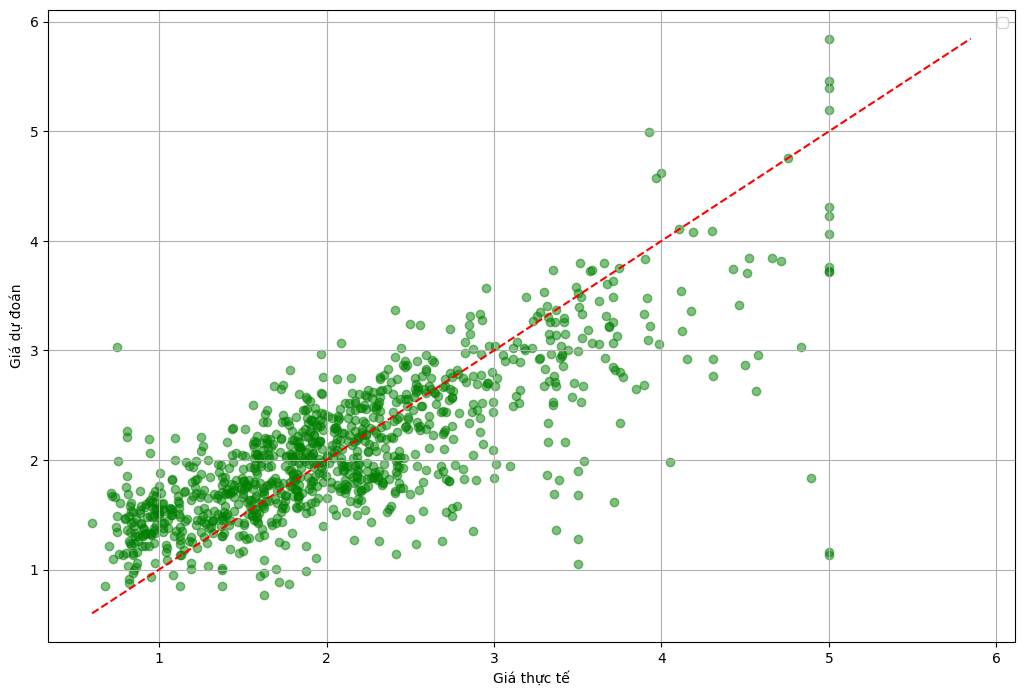

In [4]:
# --- MAIN ENTRY ---
if __name__ == "__main__":
    root = tk.Tk()
    app = LinearRegressionApp(root)
    root.mainloop()